# TF DEA from Chiara samples

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## Functions

In [108]:
def is_sig(row):
    if row.padj < 0.01 and np.abs(row.log2FoldChange) >= 1:
        return "sig"
    else:
        return "not sig"

In [109]:
def is_sig_voom(row):
    if row['adj.P.Val']< 0.01 and np.abs(row.logFC) >= 1:
        return "sig"
    else:
        return "not sig"

## variables

In [51]:
hESC_expr_f = "../../../../for_winona/RNA-Seq/diff_expr/hESC.tpm.txt"
mESC_expr_f = "../../../../for_winona/RNA-Seq/diff_expr/mESC.tpm.txt"
orth_expr_f = "../../../../for_winona/RNA-Seq/diff_expr/orth.tpm.txt"
orth_de_f = "../../../../for_winona/RNA-Seq/diff_expr/orth.DESeq2.txt"

In [85]:
ort_counts_voom = "../../../../for_winona/RNA-Seq/diff_expr/orth.cpm.txt"

In [7]:
orth_de_f_s = "../../../../for_winona/RNA-Seq/diff_expr/orth.voom.tt_table.simple_model.txt"
orth_de_f_1 = "../../../../for_winona/RNA-Seq/diff_expr/orth.voom.tt_table.with_interaction.txt"
DEG_genes_transfected = "../../../../for_winona/RNA-Seq/diff_expr/DEgenes_treatment.voom.txt"

In [8]:
orth_f = "../../../misc/00__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"
human_gene_map_f = "../../../misc/00__ensembl_orthologs/gencode.v25lift37.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"
mouse_gene_map_f = "../../../misc/00__ensembl_orthologs/gencode.vM13.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"

In [9]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

## 1. import data

In [10]:
hESC_expr = pd.read_table(hESC_expr_f).reset_index()
mESC_expr = pd.read_table(mESC_expr_f).reset_index()
hESC_expr.head()

index        rep1       rep2       rep3
0  ENSG00000223972    0.000000    0.00000    0.00000
1  ENSG00000227232  353.570372  427.66079  297.04687
2  ENSG00000243485    0.000000    0.00000    0.93411
3  ENSG00000237613    0.000000    0.00000    0.00000
4  ENSG00000268020    0.000000    0.00000    0.00000

In [136]:
orth_expr = pd.read_table(orth_expr_f).reset_index()
orth_expr.head()

index    hESC_rep1    hESC_rep2    hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   399.234542   455.690063   238.068316   
1  ENSG00000187642__ENSMUSG00000078486     5.444107    12.439815     9.769542   
2  ENSG00000187608__ENSMUSG00000035692   873.476786   672.404734   385.125634   
3  ENSG00000188157__ENSMUSG00000041936  5409.023143  7552.277124  5114.098201   
4  ENSG00000131591__ENSMUSG00000059939   284.303386   340.458093   234.469011   

      mESC_rep1    mESC_rep2    mESC_rep3  
0    163.467520    86.627332   150.107729  
1     17.768209     5.197640    16.511850  
2    522.385336   119.545719    97.570024  
3  12745.136106  9277.787308  9653.428026  
4   1515.628203  1217.980295  1541.606373

In [198]:
orth_expr_voom = pd.read_table(ort_counts_voom).reset_index()
orth_expr_voom.head()

index  hESC_rep1  hESC_rep2  hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   3.811535   4.027163   3.056715   
1  ENSG00000187642__ENSMUSG00000078486  -2.329611  -1.144156  -1.519844   
2  ENSG00000187608__ENSMUSG00000035692   4.940645   4.588224   3.750167   
3  ENSG00000188157__ENSMUSG00000041936   7.570874   8.077320   7.480494   
4  ENSG00000131591__ENSMUSG00000059939   3.322045   3.606814   3.034757   

   mESC_rep1  mESC_rep2  mESC_rep3  
0   2.485295   1.577430   2.378629  
1  -0.700417  -2.425184  -0.788885  
2   4.160063   2.041089   1.758272  
3   8.768165   8.316611   8.383529  
4   5.696392   5.387548   5.737095

In [135]:
orth_de = pd.read_table(orth_de_f).reset_index()
orth_de.head()

index     baseMean  log2FoldChange     lfcSE  \
0  ENSG00000187961__ENSMUSG00000078485   248.865917        1.447890  0.333796   
1  ENSG00000187642__ENSMUSG00000078486    11.188527       -0.519510  0.711960   
2  ENSG00000187608__ENSMUSG00000035692   445.084705        1.385440  0.813843   
3  ENSG00000188157__ENSMUSG00000041936  8291.958318       -0.809395  0.254149   
4  ENSG00000131591__ENSMUSG00000059939   855.740893       -2.315954  0.250449   

       stat        pvalue          padj  
0  4.337650  1.440144e-05  3.328200e-05  
1 -0.729689  4.655801e-01  5.268859e-01  
2  1.702343  8.869106e-02  1.206775e-01  
3 -3.184732  1.448879e-03  2.631294e-03  
4 -9.247209  2.304320e-20  1.477654e-19

In [14]:
orth_de_1 = pd.read_table(orth_de_f_1).reset_index()
orth_de_1.head()

index      logFC   AveExpr          t  \
0  ENSG00000188375__ENSMUSG00000016559   6.455838  5.983091  74.260924   
1  ENSG00000089220__ENSMUSG00000047104 -14.241255  2.066603 -92.964466   
2  ENSG00000022556__ENSMUSG00000035177 -13.844833  1.868671 -89.277402   
3  ENSG00000115112__ENSMUSG00000026380   7.378710  7.181576  68.957368   
4  ENSG00000137818__ENSMUSG00000091014 -15.625800  2.758420 -84.565736   

        P.Value     adj.P.Val          B  
0  4.513529e-18  6.151940e-15  30.601729  
1  2.652324e-19  2.409914e-15  30.549613  
2  4.420238e-19  2.409914e-15  30.308262  
3  1.148940e-17  1.252804e-14  30.241742  
4  8.761756e-19  2.676462e-15  30.068551

In [15]:
orth_de_Simple = pd.read_table(orth_de_f_s).reset_index()
orth_de_Simple.head()

index      logFC   AveExpr          t  \
0  ENSG00000161960__ENSMUSG00000059796   8.244434  6.593950  78.474587   
1  ENSG00000115112__ENSMUSG00000026380   7.218104  7.299508  67.676517   
2  ENSG00000188375__ENSMUSG00000016559   6.498921  6.023370  72.285166   
3  ENSG00000115414__ENSMUSG00000026193   4.419985  9.620076  53.228394   
4  ENSG00000263809__ENSMUSG00000060938  10.242190  4.522586  76.202726   

        P.Value     adj.P.Val          B  
0  4.800158e-10  7.291444e-07  12.932170  
1  1.137370e-09  7.291444e-07  12.696076  
2  7.747966e-10  7.291444e-07  12.680338  
3  4.606609e-09  8.974813e-07  11.927514  
4  5.696553e-10  7.291444e-07  11.793898

In [16]:
DEGenes_trans = pd.read_table(DEG_genes_transfected)
DEGenes_trans.head()

x
1  ENSG00000149591__ENSMUSG00000032085
2  ENSG00000106366__ENSMUSG00000037411
3  ENSG00000159176__ENSMUSG00000026421
4  ENSG00000130766__ENSMUSG00000028893
5  ENSG00000142227__ENSMUSG00000040212

In [17]:
orth = pd.read_table(orth_f)
orth.head()

Gene stable ID Transcript stable ID Gene name Mouse gene stable ID  \
0  ENSG00000198888      ENST00000361390    MT-ND1   ENSMUSG00000064341   
1  ENSG00000198763      ENST00000361453    MT-ND2   ENSMUSG00000064345   
2  ENSG00000198804      ENST00000361624    MT-CO1   ENSMUSG00000064351   
3  ENSG00000198712      ENST00000361739    MT-CO2   ENSMUSG00000064354   
4  ENSG00000228253      ENST00000361851   MT-ATP8   ENSMUSG00000064356   

  Mouse protein or transcript stable ID Mouse gene name  \
0                    ENSMUSP00000080991          mt-Nd1   
1                    ENSMUSP00000080992          mt-Nd2   
2                    ENSMUSP00000080993          mt-Co1   
3                    ENSMUSP00000080994          mt-Co2   
4                    ENSMUSP00000080995         mt-Atp8   

   %id. target Mouse gene identical to query gene  \
0                                         77.0440   
1                                         57.0605   
2                                         90.8382   
3                                         71.3656   
4                                         45.5882   

   %id. query gene identical to target Mouse gene  \
0                                         77.0440   
1                                         57.3913   
2                                         90.6615   
3                                         71.3656   
4                                         46.2687   

   Mouse orthology confidence [0 low, 1 high] Mouse homology type  
0                                         1.0    ortholog_one2one  
1                                         1.0    ortholog_one2one  
2                                         1.0    ortholog_one2one  
3                                         1.0    ortholog_one2one  
4                                         0.0    ortholog_one2one

In [18]:
human_gene_map = pd.read_table(human_gene_map_f, header=None)
human_gene_map.columns = ["gene_id", "biotype", "gene_name"]
human_gene_map.head()

gene_id                             biotype  gene_name
0  ENSG00000223972.5_1  transcribed_unprocessed_pseudogene    DDX11L1
1  ENSG00000227232.5_1              unprocessed_pseudogene     WASH7P
2  ENSG00000243485.4_2                             lincRNA  MIR1302-2
3  ENSG00000237613.2_1                             lincRNA    FAM138A
4  ENSG00000268020.3_1              unprocessed_pseudogene     OR4G4P

In [19]:
mouse_gene_map = pd.read_table(mouse_gene_map_f, header=None)
mouse_gene_map.columns = ["gene_id", "biotype", "gene_name"]
mouse_gene_map.head()

gene_id               biotype      gene_name
0  ENSMUSG00000102693.1                   TEC  4933401J01Rik
1  ENSMUSG00000064842.1                 snRNA        Gm26206
2  ENSMUSG00000051951.5        protein_coding           Xkr4
3  ENSMUSG00000102851.1  processed_pseudogene        Gm18956
4  ENSMUSG00000103377.1                   TEC        Gm37180

In [20]:
motif_info = pd.read_table(motif_info_f)
motif_info.head()

Ensembl ID HGNC symbol  \
0  ENSG00000267281  AC023509.3   
1  ENSG00000267281  AC023509.3   
2  ENSG00000267281  AC023509.3   
3  ENSG00000264668  AC138696.1   
4  ENSG00000264668  AC138696.1   

                                      Motif evidence  \
0   Inferred - ATF7 (100% AA Identity, Homo sapiens)   
1   Inferred - ATF7 (100% AA Identity, Homo sapiens)   
2    Inferred - Atf7 (98% AA Identity, Mus musculus)   
3  Inferred - ZFP41 (100% AA Identity, Homo sapiens)   
4  Inferred - ZFP41 (100% AA Identity, Homo sapiens)   

                    Motif ID       Motif type Motif source     CIS-BP ID  \
0         ATF7_eDBD_HT-SELEX         HT-SELEX      Yin2017  M08490_1.94d   
1  ATF7_eDBD_Methyl-HT-SELEX  Methyl-HT-SELEX      Yin2017  M08491_1.94d   
2        3T3L1-Atf7_GSE56872             Misc        HOMER  M06975_1.94d   
3          ZFP41_FL_HT-SELEX         HT-SELEX      Yin2017  M09315_1.94d   
4   ZFP41_FL_Methyl-HT-SELEX  Methyl-HT-SELEX      Yin2017  M09316_1.94d   

  Best Motif(s)? (Figure 2A)  
0                       True  
1                        NaN  
2                        NaN  
3                       True  
4                        NaN

In [21]:
motif_info["short_id"] = motif_info["CIS-BP ID"].str.split(".", expand=True)[0]
motif_info = motif_info[motif_info["Best Motif(s)? (Figure 2A)"] == True]
motif_map = motif_info[["short_id","Ensembl ID", "HGNC symbol"]]
motif_map.columns = ["index", "gene_id", "gene_name"]
motif_map = motif_map.sort_values(by="index")
print(len(motif_map))
motif_map.head()

1496


index          gene_id gene_name
8042      HKR1  ENSG00000181666      HKR1
590   M00140_1  ENSG00000179361    ARID3B
603   M00142_1  ENSG00000205143    ARID3C
574   M00142_1  ENSG00000116017    ARID3A
619   M00143_1  ENSG00000150347    ARID5B

## 2. QC on RNA-Seq

In [22]:
human_gene_map["index"] = human_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map["index"] = mouse_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map.head()

gene_id               biotype      gene_name  \
0  ENSMUSG00000102693.1                   TEC  4933401J01Rik   
1  ENSMUSG00000064842.1                 snRNA        Gm26206   
2  ENSMUSG00000051951.5        protein_coding           Xkr4   
3  ENSMUSG00000102851.1  processed_pseudogene        Gm18956   
4  ENSMUSG00000103377.1                   TEC        Gm37180   

                index  
0  ENSMUSG00000102693  
1  ENSMUSG00000064842  
2  ENSMUSG00000051951  
3  ENSMUSG00000102851  
4  ENSMUSG00000103377

In [23]:
hESC_expr = hESC_expr.merge(human_gene_map, on="index", how="left")
hESC_expr.sample(5)

index       rep1       rep2       rep3              gene_id  \
920    ENSG00000223062   0.000000   0.000000   0.000000    ENSG00000223062.1   
35817  ENSG00000254626   0.000000   0.000000   0.000000  ENSG00000254626.1_1   
10628  ENSG00000242960  15.109845  26.140635  27.089180  ENSG00000242960.1_1   
44261  ENSG00000260608   2.014646   1.045625   7.472877  ENSG00000260608.1_2   
4086   ENSG00000264809   0.000000   0.000000   0.000000    ENSG00000264809.1   

                    biotype      gene_name  
920                   snRNA     RNU6-1245P  
35817               lincRNA   RP11-27G22.1  
10628  processed_pseudogene        FTH1P23  
44261             antisense  RP11-382A20.7  
4086                  miRNA     AL513344.1

In [24]:
mESC_expr = mESC_expr.merge(mouse_gene_map, on="index", how="left")
mESC_expr.sample(5)

index         rep1         rep2         rep3  \
3433   ENSMUSG00000074309     0.000000     0.000000     0.000000   
4299   ENSMUSG00000075886     0.000000     0.000000     0.000000   
15222  ENSMUSG00000077650     0.000000     0.000000     0.000000   
1452   ENSMUSG00000029787   909.395601  1156.926236  1234.084657   
26034  ENSMUSG00000024436  1047.182813   912.490613   829.304890   

                     gene_id         biotype gene_name  
3433                     NaN             NaN       NaN  
4299                     NaN             NaN       NaN  
15222   ENSMUSG00000077650.1          snoRNA   Gm23320  
1452   ENSMUSG00000029787.10  protein_coding      Avl9  
26034  ENSMUSG00000024436.16  protein_coding   Mrps18b

In [25]:
human_genes_to_check = ["XIST", "SRY", "RPS4Y1", "DDX3Y", "POU5F1", "NANOG", "SOX2", "EOMES", "SOX17", "FOXA2"]

In [27]:
human_sub = hESC_expr[hESC_expr["gene_name"].isin(human_genes_to_check)]
human_sub = pd.melt(human_sub[["gene_name", "rep1", "rep2","rep3",]], id_vars="gene_name")
human_sub.head()

gene_name variable        value
0     EOMES     rep1     9.065907
1      SOX2     rep1  8313.436692
2    POU5F1     rep1  4706.213041
3      XIST     rep1     6.043938
4     SOX17     rep1     1.007323

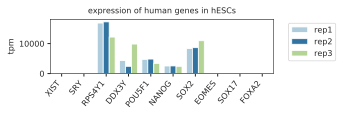

In [28]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=human_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=human_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(human_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of human genes in hESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [29]:
mouse_genes_to_check = ["Xist", "Sry", "Eif2s3y", "Ddx3y", "Pou5f1", "Nanog", "Sox2", "Eomes", "Sox17", "Foxa2"]

In [30]:
mouse_sub = mESC_expr[mESC_expr["gene_name"].isin(mouse_genes_to_check)]
mouse_sub = pd.melt(mouse_sub[["gene_name", "rep1", "rep2","rep3"]], id_vars="gene_name")
mouse_sub.head()

gene_name variable         value
0     Nanog     rep1  13577.339914
1     Sox17     rep1      4.239607
2      Xist     rep1      9.539115
3     Eomes     rep1    316.910588
4      Sox2     rep1   8294.790177

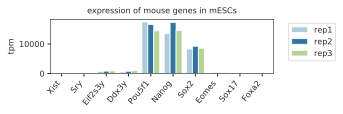

In [31]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=mouse_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=mouse_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(mouse_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of mouse genes in mESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

## 3. Look at TF expression

In [32]:
uniq_human_TFs = motif_map["gene_name"].unique()
print(len(uniq_human_TFs))

TFs_in_seq = [x for x in uniq_human_TFs if x in list(hESC_expr["gene_name"])]
print(len(TFs_in_seq))

TFs_missing = [x for x in uniq_human_TFs if x not in list(hESC_expr["gene_name"])]
print(len(TFs_missing))

1208
1195
13


In [33]:
## Differentially expressed genes between transfected and untransfected samples
DEGenes_trans_human = pd.DataFrame(columns=['index'])
DEGenes_trans_mouse = pd.DataFrame(columns=['index'])
DEGenes_trans_human['index'] = DEGenes_trans.apply(lambda row: row['x'].split('__')[0], axis=1)
DEGenes_trans_mouse['index'] = DEGenes_trans.apply(lambda row: row['x'].split('__')[1], axis=1)
print(len(DEGenes_trans_human))
print(len(DEGenes_trans_mouse))

2737
2737


In [34]:
DEGenes_trans_human = DEGenes_trans_human.merge(human_gene_map, how='left', on='index')
DEGenes_trans_mouse = DEGenes_trans_mouse.merge(mouse_gene_map, how='left', on='index')
DEGenes_trans_human.head()

index               gene_id         biotype gene_name
0  ENSG00000149591  ENSG00000149591.16_2  protein_coding     TAGLN
1  ENSG00000106366   ENSG00000106366.8_1  protein_coding  SERPINE1
2  ENSG00000159176  ENSG00000159176.13_1  protein_coding     CSRP1
3  ENSG00000130766   ENSG00000130766.4_1  protein_coding     SESN2
4  ENSG00000142227  ENSG00000142227.10_2  protein_coding      EMP3

In [35]:
DEGenes_trans_human_list = DEGenes_trans_human['gene_name'].values.tolist()
DEGenes_trans_mouse_list = DEGenes_trans_mouse['gene_name'].values.tolist()

TFs_DE_trans = [x for x in DEGenes_trans_human_list if x in uniq_human_TFs]
print(len(TFs_DE_trans))

97


In [36]:
TFs_DE_trans

['BHLHE40',
 'JUN',
 'ATF3',
 'ISL2',
 'JUND',
 'FOSL2',
 'MAFF',
 'EGR1',
 'POU3F3',
 'ZNF398',
 'RELB',
 'EPAS1',
 'FOSL1',
 'JDP2',
 'MAFG',
 'FOXB1',
 'NEUROD1',
 'ZBTB7B',
 'NKX1-1',
 'FOXF2',
 'TFAP2D',
 'TFAP2B',
 'FERD3L',
 'NEUROD6',
 'PTF1A',
 'HOXB5',
 'HOXB6',
 'HSFY1',
 'HSFY2',
 'ISX',
 'EN2',
 'FOXS1',
 'MYF5',
 'ZIC3',
 'KLF10',
 'SOX14',
 'FOXL2',
 'ZFP57',
 'HES3',
 'XBP1',
 'RXRB',
 'ZBTB12',
 'TFDP2',
 'IRF6',
 'HOXB13',
 'FOXB2',
 'SOX2',
 'JUNB',
 'HOXA7',
 'ZBTB22',
 'OTX2',
 'CEBPB',
 'PHOX2B',
 'HESX1',
 'PRDM1',
 'SRY',
 'GATA4',
 'IRX2',
 'HOXB1',
 'ETV5',
 'EGR4',
 'PBX1',
 'CREB3L1',
 'FOXI2',
 'HOXC11',
 'PROP1',
 'NHLH2',
 'HOXB9',
 'CCDC169-SOHLH2',
 'SOX21',
 'PRDM14',
 'CIC',
 'DDIT3',
 'SMAD3',
 'NFKB2',
 'SCX',
 'PAX6',
 'ZIC5',
 'TEAD3',
 'HOXD8',
 'TFAP2A',
 'FOXD4L1',
 'ZNF524',
 'NR2C2',
 'GTF2I',
 'ATF4',
 'FOXD3',
 'ELF4',
 'ARID5A',
 'NR3C2',
 'ZNF768',
 'ZNF521',
 'SALL4',
 'CXXC5',
 'GLIS2',
 'SRF',
 'BNC2']

In [37]:
uniq_human_TFs_filtered = set(uniq_human_TFs)-set(TFs_DE_trans)
len(uniq_human_TFs_filtered)

1111

In [38]:
hESC_TFs = hESC_expr[hESC_expr["gene_name"].isin(uniq_human_TFs_filtered)].drop_duplicates(subset=["index", "rep1", "rep2",
                                                                                          "biotype", "gene_name"])
print(len(hESC_TFs))
hESC_TFs.head()

1099


index        rep1        rep2       rep3               gene_id  \
71   ENSG00000188290   13.095199   11.501879   6.538768  ENSG00000188290.10_1   
172  ENSG00000197921    1.007323    4.182502   2.802329   ENSG00000197921.5_1   
187  ENSG00000142611   73.534579   51.235645  42.034934  ENSG00000142611.16_2   
197  ENSG00000078900  116.849468  153.706934  83.135759  ENSG00000078900.14_2   
238  ENSG00000069812    6.043938   15.684381  16.813974  ENSG00000069812.11_1   

            biotype gene_name  
71   protein_coding      HES4  
172  protein_coding      HES5  
187  protein_coding    PRDM16  
197  protein_coding      TP73  
238  protein_coding      HES2

In [39]:
tmp = hESC_TFs.groupby("gene_name")["index"].agg("count").reset_index()
tmp.sort_values(by="index", ascending=False).head()

gene_name  index
1031    ZNF727      2
0          AHR      1
729     ZBTB11      1
735     ZBTB26      1
734     ZBTB20      1

In [40]:
hESC_TFs = hESC_TFs[hESC_TFs["index"] != "ENSG00000214652"]
len(hESC_TFs)

1098

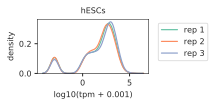

In [41]:
fig = plt.figure(figsize=(2, 1))

ax = sns.distplot(np.log10(hESC_TFs["rep1"]+0.001), label="rep 1", color=sns.color_palette("Set2")[0], hist=False)
sns.distplot(np.log10(hESC_TFs["rep2"]+0.001), label="rep 2", color=sns.color_palette("Set2")[1], hist=False)
sns.distplot(np.log10(hESC_TFs["rep3"]+0.001), label="rep 3", color=sns.color_palette("Set2")[2], hist=False)


ax.set_xlabel("log10(tpm + 0.001)")
ax.set_ylabel("density")
ax.set_title("hESCs")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [42]:
hESC_TFs["mean_tpm"] = hESC_TFs[["rep1", "rep2","rep3"]].mean(axis=1)
hESC_TFs.head()

index        rep1        rep2       rep3               gene_id  \
71   ENSG00000188290   13.095199   11.501879   6.538768  ENSG00000188290.10_1   
172  ENSG00000197921    1.007323    4.182502   2.802329   ENSG00000197921.5_1   
187  ENSG00000142611   73.534579   51.235645  42.034934  ENSG00000142611.16_2   
197  ENSG00000078900  116.849468  153.706934  83.135759  ENSG00000078900.14_2   
238  ENSG00000069812    6.043938   15.684381  16.813974  ENSG00000069812.11_1   

            biotype gene_name    mean_tpm  
71   protein_coding      HES4   10.378615  
172  protein_coding      HES5    2.664051  
187  protein_coding    PRDM16   55.601719  
197  protein_coding      TP73  117.897387  
238  protein_coding      HES2   12.847431

In [43]:
hESC_TFs_expr = list(hESC_TFs[hESC_TFs["mean_tpm"] > 1]["gene_name"])
len(hESC_TFs_expr)

954

## 4. Look at expression of orthologous TF

In [44]:
human_mouse_TFs = hESC_TFs[["index", "gene_name", "mean_tpm"]]
print(len(human_mouse_TFs))
human_mouse_TFs = human_mouse_TFs.merge(orth[["Gene stable ID", 
                                              "Mouse gene stable ID", 
                                              "Gene name",
                                              "Mouse gene name"]].drop_duplicates(),
                                        left_on=["index", "gene_name"],
                                        right_on=["Gene stable ID", "Gene name"])
human_mouse_TFs.drop(["Gene stable ID", "Gene name"], axis=1, inplace=True)
human_mouse_TFs.columns = ["gene_id_human", "gene_name_human", "mean_tpm_human", "gene_id_mouse", "gene_name_mouse"]
print(len(human_mouse_TFs))
human_mouse_TFs.head()

1098
988


gene_id_human gene_name_human  mean_tpm_human       gene_id_mouse  \
0  ENSG00000197921            HES5        2.664051  ENSMUSG00000048001   
1  ENSG00000142611          PRDM16       55.601719  ENSMUSG00000039410   
2  ENSG00000078900            TP73      117.897387  ENSMUSG00000029026   
3  ENSG00000069812            HES2       12.847431  ENSMUSG00000028940   
4  ENSG00000204859          ZBTB48     1251.437325  ENSMUSG00000028952   

  gene_name_mouse  
0            Hes5  
1          Prdm16  
2           Trp73  
3            Hes2  
4          Zbtb48

In [45]:
mESC_expr["mean_tpm_mouse"] = mESC_expr[["rep1", "rep2", "rep3"]].mean(axis=1)
mESC_expr.head()

index      rep1  rep2      rep3               gene_id  \
0  ENSMUSG00000000702  0.000000   0.0  0.000000                   NaN   
1  ENSMUSG00000078423  0.000000   0.0  0.000000                   NaN   
2  ENSMUSG00000078424  0.000000   0.0  0.000000                   NaN   
3  ENSMUSG00000071964  2.119803   0.0  0.000000                   NaN   
4  ENSMUSG00000093774  0.000000   0.0  4.487581  ENSMUSG00000093774.1   

                  biotype    gene_name  mean_tpm_mouse  
0                     NaN          NaN        0.000000  
1                     NaN          NaN        0.000000  
2                     NaN          NaN        0.000000  
3                     NaN          NaN        0.706601  
4  unprocessed_pseudogene  Vmn1r-ps151        1.495860

In [46]:
human_mouse_TFs = human_mouse_TFs.merge(mESC_expr[["index", "gene_name", "mean_tpm_mouse"]],
                                        left_on=["gene_id_mouse", "gene_name_mouse"],
                                        right_on=["index", "gene_name"])
human_mouse_TFs.drop(["index", "gene_name"], axis=1, inplace=True)
print(len(human_mouse_TFs))
human_mouse_TFs.head()

935


gene_id_human gene_name_human  mean_tpm_human       gene_id_mouse  \
0  ENSG00000197921            HES5        2.664051  ENSMUSG00000048001   
1  ENSG00000142611          PRDM16       55.601719  ENSMUSG00000039410   
2  ENSG00000078900            TP73      117.897387  ENSMUSG00000029026   
3  ENSG00000069812            HES2       12.847431  ENSMUSG00000028940   
4  ENSG00000204859          ZBTB48     1251.437325  ENSMUSG00000028952   

  gene_name_mouse  mean_tpm_mouse  
0            Hes5        0.000000  
1          Prdm16      612.953260  
2           Trp73      239.674040  
3            Hes2        1.949365  
4          Zbtb48      342.804146

In [47]:
human_mouse_TFs[human_mouse_TFs["gene_name_mouse"] == "Zfy2"]

gene_id_human gene_name_human  mean_tpm_human       gene_id_mouse  \
806  ENSG00000171469          ZNF561     3182.793224  ENSMUSG00000000103   
807  ENSG00000171466          ZNF562     1507.228348  ENSMUSG00000000103   
808  ENSG00000180884          ZNF792      376.885200  ENSMUSG00000000103   
809  ENSG00000188227          ZNF793      640.945560  ENSMUSG00000000103   
810  ENSG00000198464          ZNF480     1331.634032  ENSMUSG00000000103   
811  ENSG00000167554          ZNF610      152.031196  ENSMUSG00000000103   
812  ENSG00000131845          ZNF304      896.766293  ENSMUSG00000000103   
813  ENSG00000188785          ZNF548      399.018642  ENSMUSG00000000103   
814  ENSG00000105136          ZNF419      562.536719  ENSMUSG00000000103   
815  ENSG00000121406          ZNF549      853.335795  ENSMUSG00000000103   
816  ENSG00000213762          ZNF134     3022.199112  ENSMUSG00000000103   
817  ENSG00000179909          ZNF154      878.543698  ENSMUSG00000000103   
818  ENSG00000083828          ZNF586      632.336657  ENSMUSG00000000103   
819  ENSG00000178935          ZNF552      735.580424  ENSMUSG00000000103   
820  ENSG00000196724          ZNF418      658.672262  ENSMUSG00000000103   
821  ENSG00000171574          ZNF584      301.496304  ENSMUSG00000000103   

    gene_name_mouse  mean_tpm_mouse  
806            Zfy2             0.0  
807            Zfy2             0.0  
808            Zfy2             0.0  
809            Zfy2             0.0  
810            Zfy2             0.0  
811            Zfy2             0.0  
812            Zfy2             0.0  
813            Zfy2             0.0  
814            Zfy2             0.0  
815            Zfy2             0.0  
816            Zfy2             0.0  
817            Zfy2             0.0  
818            Zfy2             0.0  
819            Zfy2             0.0  
820            Zfy2             0.0  
821            Zfy2             0.0

In [48]:
mESC_TFs_expr = list(human_mouse_TFs[human_mouse_TFs["mean_tpm_mouse"] > 1]["gene_name_mouse"].unique())
len(mESC_TFs_expr)

737

## 5. Look at orthologous expression

In [137]:
orth_expr["gene_id_human"] = orth_expr["index"].str.split("__", expand=True)[0]
orth_expr["gene_id_mouse"] = orth_expr["index"].str.split("__", expand=True)[1]
orth_expr.head()

index    hESC_rep1    hESC_rep2    hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   399.234542   455.690063   238.068316   
1  ENSG00000187642__ENSMUSG00000078486     5.444107    12.439815     9.769542   
2  ENSG00000187608__ENSMUSG00000035692   873.476786   672.404734   385.125634   
3  ENSG00000188157__ENSMUSG00000041936  5409.023143  7552.277124  5114.098201   
4  ENSG00000131591__ENSMUSG00000059939   284.303386   340.458093   234.469011   

      mESC_rep1    mESC_rep2    mESC_rep3    gene_id_human       gene_id_mouse  
0    163.467520    86.627332   150.107729  ENSG00000187961  ENSMUSG00000078485  
1     17.768209     5.197640    16.511850  ENSG00000187642  ENSMUSG00000078486  
2    522.385336   119.545719    97.570024  ENSG00000187608  ENSMUSG00000035692  
3  12745.136106  9277.787308  9653.428026  ENSG00000188157  ENSMUSG00000041936  
4   1515.628203  1217.980295  1541.606373  ENSG00000131591  ENSMUSG00000059939

In [180]:
orth_expr_voom["gene_id_human"] = orth_expr_voom["index"].str.split("__", expand=True)[0]
orth_expr_voom["gene_id_mouse"] = orth_expr_voom["index"].str.split("__", expand=True)[1]
orth_expr_voom.head()

index  hESC_rep1  hESC_rep2  hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   3.811535   4.027163   3.056715   
1  ENSG00000187642__ENSMUSG00000078486  -2.329611  -1.144156  -1.519844   
2  ENSG00000187608__ENSMUSG00000035692   4.940645   4.588224   3.750167   
3  ENSG00000188157__ENSMUSG00000041936   7.570874   8.077320   7.480494   
4  ENSG00000131591__ENSMUSG00000059939   3.322045   3.606814   3.034757   

   mESC_rep1  mESC_rep2  mESC_rep3    gene_id_human       gene_id_mouse  
0   2.485295   1.577430   2.378629  ENSG00000187961  ENSMUSG00000078485  
1  -0.700417  -2.425184  -0.788885  ENSG00000187642  ENSMUSG00000078486  
2   4.160063   2.041089   1.758272  ENSG00000187608  ENSMUSG00000035692  
3   8.768165   8.316611   8.383529  ENSG00000188157  ENSMUSG00000041936  
4   5.696392   5.387548   5.737095  ENSG00000131591  ENSMUSG00000059939

In [138]:
orth_sub = orth[["Gene stable ID", "Mouse gene stable ID", "Gene name", "Mouse gene name"]].drop_duplicates()
orth_sub.columns = ["gene_id_human", "gene_id_mouse", "gene_name_human", "gene_name_mouse"]
orth_expr = orth_expr.merge(orth_sub, on=["gene_id_human", "gene_id_mouse"]).drop_duplicates()
orth_expr.head()

index    hESC_rep1    hESC_rep2    hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   399.234542   455.690063   238.068316   
1  ENSG00000187642__ENSMUSG00000078486     5.444107    12.439815     9.769542   
2  ENSG00000187608__ENSMUSG00000035692   873.476786   672.404734   385.125634   
3  ENSG00000188157__ENSMUSG00000041936  5409.023143  7552.277124  5114.098201   
4  ENSG00000131591__ENSMUSG00000059939   284.303386   340.458093   234.469011   

      mESC_rep1    mESC_rep2    mESC_rep3    gene_id_human  \
0    163.467520    86.627332   150.107729  ENSG00000187961   
1     17.768209     5.197640    16.511850  ENSG00000187642   
2    522.385336   119.545719    97.570024  ENSG00000187608   
3  12745.136106  9277.787308  9653.428026  ENSG00000188157   
4   1515.628203  1217.980295  1541.606373  ENSG00000131591   

        gene_id_mouse gene_name_human gene_name_mouse  
0  ENSMUSG00000078485          KLHL17         Plekhn1  
1  ENSMUSG00000078486           PERM1           Perm1  
2  ENSMUSG00000035692           ISG15           Isg15  
3  ENSMUSG00000041936            AGRN            Agrn  
4  ENSMUSG00000059939        C1orf159   9430015G10Rik

In [181]:
orth_sub = orth[["Gene stable ID", "Mouse gene stable ID", "Gene name", "Mouse gene name"]].drop_duplicates()
orth_sub.columns = ["gene_id_human", "gene_id_mouse", "gene_name_human", "gene_name_mouse"]
orth_expr_voom = orth_expr_voom.merge(orth_sub, on=["gene_id_human", "gene_id_mouse"]).drop_duplicates()
orth_expr_voom.head()

index  hESC_rep1  hESC_rep2  hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   3.811535   4.027163   3.056715   
1  ENSG00000187642__ENSMUSG00000078486  -2.329611  -1.144156  -1.519844   
2  ENSG00000187608__ENSMUSG00000035692   4.940645   4.588224   3.750167   
3  ENSG00000188157__ENSMUSG00000041936   7.570874   8.077320   7.480494   
4  ENSG00000131591__ENSMUSG00000059939   3.322045   3.606814   3.034757   

   mESC_rep1  mESC_rep2  mESC_rep3    gene_id_human       gene_id_mouse  \
0   2.485295   1.577430   2.378629  ENSG00000187961  ENSMUSG00000078485   
1  -0.700417  -2.425184  -0.788885  ENSG00000187642  ENSMUSG00000078486   
2   4.160063   2.041089   1.758272  ENSG00000187608  ENSMUSG00000035692   
3   8.768165   8.316611   8.383529  ENSG00000188157  ENSMUSG00000041936   
4   5.696392   5.387548   5.737095  ENSG00000131591  ENSMUSG00000059939   

  gene_name_human gene_name_mouse  
0          KLHL17         Plekhn1  
1           PERM1           Perm1  
2           ISG15           Isg15  
3            AGRN            Agrn  
4        C1orf159   9430015G10Rik

In [139]:
orth_expr["mean_tpm_hESC"] = orth_expr[["hESC_rep1", "hESC_rep2","hESC_rep3"]].mean(axis=1)
orth_expr["mean_tpm_mESC"] = orth_expr[["mESC_rep1", "mESC_rep2", "mESC_rep3"]].mean(axis=1)
orth_expr.head()

index    hESC_rep1    hESC_rep2    hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   399.234542   455.690063   238.068316   
1  ENSG00000187642__ENSMUSG00000078486     5.444107    12.439815     9.769542   
2  ENSG00000187608__ENSMUSG00000035692   873.476786   672.404734   385.125634   
3  ENSG00000188157__ENSMUSG00000041936  5409.023143  7552.277124  5114.098201   
4  ENSG00000131591__ENSMUSG00000059939   284.303386   340.458093   234.469011   

      mESC_rep1    mESC_rep2    mESC_rep3    gene_id_human  \
0    163.467520    86.627332   150.107729  ENSG00000187961   
1     17.768209     5.197640    16.511850  ENSG00000187642   
2    522.385336   119.545719    97.570024  ENSG00000187608   
3  12745.136106  9277.787308  9653.428026  ENSG00000188157   
4   1515.628203  1217.980295  1541.606373  ENSG00000131591   

        gene_id_mouse gene_name_human gene_name_mouse  mean_tpm_hESC  \
0  ENSMUSG00000078485          KLHL17         Plekhn1     364.330974   
1  ENSMUSG00000078486           PERM1           Perm1       9.217821   
2  ENSMUSG00000035692           ISG15           Isg15     643.669051   
3  ENSMUSG00000041936            AGRN            Agrn    6025.132822   
4  ENSMUSG00000059939        C1orf159   9430015G10Rik     286.410163   

   mean_tpm_mESC  
0     133.400860  
1      13.159233  
2     246.500359  
3   10558.783814  
4    1425.071623

In [182]:
orth_expr_voom["mean_tpm_hESC"] = orth_expr_voom[["hESC_rep1", "hESC_rep2","hESC_rep3"]].mean(axis=1)
orth_expr_voom["mean_tpm_mESC"] = orth_expr_voom[["mESC_rep1", "mESC_rep2", "mESC_rep3"]].mean(axis=1)
orth_expr_voom.head()

index  hESC_rep1  hESC_rep2  hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   3.811535   4.027163   3.056715   
1  ENSG00000187642__ENSMUSG00000078486  -2.329611  -1.144156  -1.519844   
2  ENSG00000187608__ENSMUSG00000035692   4.940645   4.588224   3.750167   
3  ENSG00000188157__ENSMUSG00000041936   7.570874   8.077320   7.480494   
4  ENSG00000131591__ENSMUSG00000059939   3.322045   3.606814   3.034757   

   mESC_rep1  mESC_rep2  mESC_rep3    gene_id_human       gene_id_mouse  \
0   2.485295   1.577430   2.378629  ENSG00000187961  ENSMUSG00000078485   
1  -0.700417  -2.425184  -0.788885  ENSG00000187642  ENSMUSG00000078486   
2   4.160063   2.041089   1.758272  ENSG00000187608  ENSMUSG00000035692   
3   8.768165   8.316611   8.383529  ENSG00000188157  ENSMUSG00000041936   
4   5.696392   5.387548   5.737095  ENSG00000131591  ENSMUSG00000059939   

  gene_name_human gene_name_mouse  mean_tpm_hESC  mean_tpm_mESC  
0          KLHL17         Plekhn1       3.631805       2.147118  
1           PERM1           Perm1      -1.664537      -1.304829  
2           ISG15           Isg15       4.426345       2.653141  
3            AGRN            Agrn       7.709563       8.489435  
4        C1orf159   9430015G10Rik       3.321205       5.607011

In [140]:
orth_expr= orth_expr.merge(orth_de, on="index")
orth_expr.head()

index    hESC_rep1    hESC_rep2    hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   399.234542   455.690063   238.068316   
1  ENSG00000187642__ENSMUSG00000078486     5.444107    12.439815     9.769542   
2  ENSG00000187608__ENSMUSG00000035692   873.476786   672.404734   385.125634   
3  ENSG00000188157__ENSMUSG00000041936  5409.023143  7552.277124  5114.098201   
4  ENSG00000131591__ENSMUSG00000059939   284.303386   340.458093   234.469011   

      mESC_rep1    mESC_rep2    mESC_rep3    gene_id_human  \
0    163.467520    86.627332   150.107729  ENSG00000187961   
1     17.768209     5.197640    16.511850  ENSG00000187642   
2    522.385336   119.545719    97.570024  ENSG00000187608   
3  12745.136106  9277.787308  9653.428026  ENSG00000188157   
4   1515.628203  1217.980295  1541.606373  ENSG00000131591   

        gene_id_mouse gene_name_human gene_name_mouse  mean_tpm_hESC  \
0  ENSMUSG00000078485          KLHL17         Plekhn1     364.330974   
1  ENSMUSG00000078486           PERM1           Perm1       9.217821   
2  ENSMUSG00000035692           ISG15           Isg15     643.669051   
3  ENSMUSG00000041936            AGRN            Agrn    6025.132822   
4  ENSMUSG00000059939        C1orf159   9430015G10Rik     286.410163   

   mean_tpm_mESC     baseMean  log2FoldChange     lfcSE      stat  \
0     133.400860   248.865917        1.447890  0.333796  4.337650   
1      13.159233    11.188527       -0.519510  0.711960 -0.729689   
2     246.500359   445.084705        1.385440  0.813843  1.702343   
3   10558.783814  8291.958318       -0.809395  0.254149 -3.184732   
4    1425.071623   855.740893       -2.315954  0.250449 -9.247209   

         pvalue          padj  
0  1.440144e-05  3.328200e-05  
1  4.655801e-01  5.268859e-01  
2  8.869106e-02  1.206775e-01  
3  1.448879e-03  2.631294e-03  
4  2.304320e-20  1.477654e-19

In [183]:
orth_expr_voom= orth_expr_voom.merge(orth_de_1, on="index")
orth_expr_voom.head()

index  hESC_rep1  hESC_rep2  hESC_rep3  \
0  ENSG00000187961__ENSMUSG00000078485   3.811535   4.027163   3.056715   
1  ENSG00000188157__ENSMUSG00000041936   7.570874   8.077320   7.480494   
2  ENSG00000131591__ENSMUSG00000059939   3.322045   3.606814   3.034757   
3  ENSG00000078808__ENSMUSG00000029076   6.734844   7.004384   6.331238   
4  ENSG00000176022__ENSMUSG00000050796   4.608532   4.885415   4.397038   

   mESC_rep1  mESC_rep2  mESC_rep3    gene_id_human       gene_id_mouse  \
0   2.485295   1.577430   2.378629  ENSG00000187961  ENSMUSG00000078485   
1   8.768165   8.316611   8.383529  ENSG00000188157  ENSMUSG00000041936   
2   5.696392   5.387548   5.737095  ENSG00000131591  ENSMUSG00000059939   
3   7.052618   6.983918   6.804900  ENSG00000078808  ENSMUSG00000029076   
4   3.189796   3.485471   3.019420  ENSG00000176022  ENSMUSG00000050796   

  gene_name_human gene_name_mouse  mean_tpm_hESC  mean_tpm_mESC     logFC  \
0          KLHL17         Plekhn1       3.631805       2.147118 -1.193813   
1            AGRN            Agrn       7.709563       8.489435  0.882866   
2        C1orf159   9430015G10Rik       3.321205       5.607011  2.612572   
3            SDF4            Sdf4       6.690155       6.947145  0.447376   
4         B3GALT6         B3galt6       4.630329       3.231563 -1.296531   

    AveExpr          t       P.Value     adj.P.Val          B  
0  2.853132  -4.745636  4.128637e-04  6.712191e-04  -0.698493  
1  8.044454   7.678741  4.155290e-06  9.347902e-06   3.576486  
2  4.539635  18.349662  1.736216e-10  1.347452e-09  14.478770  
3  6.728039   4.592215  5.423024e-04  8.671749e-04  -1.472096  
4  3.809226 -11.044922  7.380684e-08  2.436542e-07   8.225506

In [142]:
orth_expr["sig"] = orth_expr.apply(is_sig, axis=1)
orth_expr.sig.value_counts()

not sig    10138
sig         8760
Name: sig, dtype: int64

In [184]:
orth_expr_voom["sig"] = orth_expr_voom.apply(is_sig_voom, axis=1)
orth_expr_voom.sig.value_counts()

not sig    5549
sig        5355
Name: sig, dtype: int64

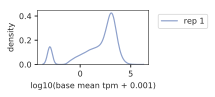

In [145]:
fig = plt.figure(figsize=(2, 1))

ax = sns.distplot(np.log10(orth_expr["baseMean"]+0.001), label="rep 1", color=sns.color_palette("Set2")[2], hist=False)

ax.set_xlabel("log10(base mean tpm + 0.001)")
ax.set_ylabel("density")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [146]:
orth_expr_filt = orth_expr[orth_expr["baseMean"] >= 1]
len(orth_expr_filt)

16050

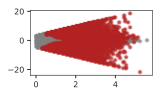

In [147]:
fig, ax = plt.subplots(figsize=(2.2, 1.2), nrows=1, ncols=1)

ax.scatter(np.log10(orth_expr_filt[orth_expr_filt["sig"] == "not sig"]["baseMean"]+0.001), 
           orth_expr_filt[orth_expr_filt["sig"] == "not sig"]["log2FoldChange"],
           color="gray", alpha=0.75, s=10, rasterized=True)
ax.scatter(np.log10(orth_expr_filt[orth_expr_filt["sig"] == "sig"]["baseMean"]+0.001), 
           orth_expr_filt[orth_expr_filt["sig"] == "sig"]["log2FoldChange"],
           color="firebrick", alpha=0.75, s=10, rasterized=True)

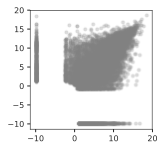

In [148]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(np.log2(orth_expr_filt["mean_tpm_hESC"]+0.001), 
           np.log2(orth_expr_filt["mean_tpm_mESC"]+0.001),
           color="gray", alpha=0.25, s=10, rasterized=True)

In [149]:
orth_tf_expr = human_mouse_TFs.merge(orth_expr, on=["gene_id_human", "gene_name_human", 
                                                    "gene_id_mouse", "gene_name_mouse"]).drop_duplicates()
print(len(orth_tf_expr))
orth_tf_expr.head()

874


gene_id_human gene_name_human  mean_tpm_human       gene_id_mouse  \
0  ENSG00000197921            HES5        2.664051  ENSMUSG00000048001   
1  ENSG00000142611          PRDM16       55.601719  ENSMUSG00000039410   
2  ENSG00000078900            TP73      117.897387  ENSMUSG00000029026   
3  ENSG00000069812            HES2       12.847431  ENSMUSG00000028940   
4  ENSG00000204859          ZBTB48     1251.437325  ENSMUSG00000028952   

  gene_name_mouse  mean_tpm_mouse                                index  \
0            Hes5        0.000000  ENSG00000197921__ENSMUSG00000048001   
1          Prdm16      612.953260  ENSG00000142611__ENSMUSG00000039410   
2           Trp73      239.674040  ENSG00000078900__ENSMUSG00000029026   
3            Hes2        1.949365  ENSG00000069812__ENSMUSG00000028940   
4          Zbtb48      342.804146  ENSG00000204859__ENSMUSG00000028952   

    hESC_rep1   hESC_rep2   hESC_rep3  ...    mESC_rep3  mean_tpm_hESC  \
0    0.604901    2.618908    1.542559  ...     0.000000       1.588790   
1   44.157760   32.081628   23.138389  ...  1152.827356      33.125926   
2   70.168495   96.244884   45.762592  ...   438.314568      70.725324   
3    3.629405    9.820907    9.255356  ...     4.503232       7.568556   
4  770.038745  890.428859  577.945544  ...   549.394287     746.137716   

   mean_tpm_mESC    baseMean  log2FoldChange     lfcSE       stat  \
0       0.000000    0.794395        2.371588  2.461285   0.963557   
1    1025.914477  529.520201       -4.958685  0.291892 -16.988080   
2     401.177928  235.951626       -2.509199  0.308207  -8.141273   
3       3.263140    5.415848        1.201402  1.024259   1.172948   
4     573.826255  659.981985        0.378597  0.252637   1.498583   

         pvalue          padj      sig  
0  3.352683e-01  3.954289e-01  not sig  
1  1.006287e-64  3.895837e-63      sig  
2  3.911430e-16  1.977797e-15      sig  
3  2.408168e-01  2.962166e-01  not sig  
4  1.339819e-01  1.751543e-01  not sig  

[5 rows x 22 columns]

In [185]:
orth_tf_expr_voom = human_mouse_TFs.merge(orth_expr_voom, on=["gene_id_human", "gene_name_human", 
                                                    "gene_id_mouse", "gene_name_mouse"]).drop_duplicates()
print(len(orth_tf_expr_voom))
orth_tf_expr_voom.head()

485


gene_id_human gene_name_human  mean_tpm_human       gene_id_mouse  \
0  ENSG00000142611          PRDM16       55.601719  ENSMUSG00000039410   
1  ENSG00000078900            TP73      117.897387  ENSMUSG00000029026   
2  ENSG00000204859          ZBTB48     1251.437325  ENSMUSG00000028952   
3  ENSG00000125945          ZNF436      136.434616  ENSMUSG00000051351   
4  ENSG00000007968            E2F2      369.977953  ENSMUSG00000018983   

  gene_name_mouse  mean_tpm_mouse                                index  \
0          Prdm16      612.953260  ENSG00000142611__ENSMUSG00000039410   
1           Trp73      239.674040  ENSG00000078900__ENSMUSG00000029026   
2          Zbtb48      342.804146  ENSG00000204859__ENSMUSG00000028952   
3           Zfp46      177.665949  ENSG00000125945__ENSMUSG00000051351   
4            E2f2      168.224002  ENSG00000007968__ENSMUSG00000018983   

   hESC_rep1  hESC_rep2  hESC_rep3  ...  mESC_rep3  mean_tpm_hESC  \
0   0.641285   0.207757  -0.294147  ...   5.317906       0.184965   
1   1.306841   1.786394   0.683091  ...   3.923215       1.258775   
2   4.758855   4.993283   4.335500  ...   4.248944       4.695879   
3   1.567070   1.587192   1.384634  ...   3.143298       1.512965   
4   3.064128   3.278163   2.436173  ...   3.046876       2.926155   

   mean_tpm_mESC     logFC   AveExpr          t       P.Value     adj.P.Val  \
0       5.134094  5.045202  2.510447  30.285845  3.535731e-13  1.212378e-11   
1       3.783483  2.444667  2.530112  12.663887  1.497764e-08  5.900151e-08   
2       4.302371 -0.123663  4.430457  -1.063249  3.075626e-01  3.399901e-01   
3       3.347454  2.042385  2.222969  11.624865  4.080128e-08  1.430998e-07   
4       3.259973  0.207420  3.107385   1.111804  2.869242e-01  3.185969e-01   

           B      sig  
0  20.596182      sig  
1  10.024410      sig  
2  -7.348258  not sig  
3   8.999678      sig  
4  -7.087465  not sig  

[5 rows x 22 columns]

In [151]:
orth_tf_expr = orth_tf_expr[["gene_id_human", "gene_name_human", "mean_tpm_hESC", "gene_id_mouse", "gene_name_mouse",
                             "mean_tpm_mESC", "baseMean", "log2FoldChange", "lfcSE", "padj", "sig"]].drop_duplicates()
len(orth_tf_expr)

874

In [186]:
orth_tf_expr_voom = orth_tf_expr_voom[["gene_id_human", "gene_name_human", "mean_tpm_hESC", "gene_id_mouse", "gene_name_mouse",
                             "mean_tpm_mESC", "AveExpr", "logFC", "adj.P.Val", "sig"]].drop_duplicates()
len(orth_tf_expr_voom)

485

In [154]:
# remove any orth pair that maps to more than one gene
tmp = orth_tf_expr.groupby("gene_name_human")["gene_name_mouse"].agg("count").reset_index()
human_dupe_orths = tmp[tmp["gene_name_mouse"] > 1]
print(len(human_dupe_orths))
human_dupe_orths

9


gene_name_human  gene_name_mouse
162           FOXG1                2
374          MTERF1                2
385            MYCN                2
761          ZNF274                2
773           ZNF34               26
797          ZNF519                2
801          ZNF566                2
807          ZNF627                2
826         ZNF780A                5

In [155]:
# remove any orth pair that maps to more than one gene
tmp = orth_tf_expr.groupby("gene_name_mouse")["gene_name_human"].agg("count").reset_index()
mouse_dupe_orths = tmp[tmp["gene_name_human"] > 1]
print(len(mouse_dupe_orths))
mouse_dupe_orths.head()

6


gene_name_mouse  gene_name_human
155           Foxd4                4
352           Mef2b                2
397           Nanog                2
506          Pou5f1                2
778          Zfp558                2

In [156]:
orth_tf_expr = orth_tf_expr[~orth_tf_expr["gene_name_human"].isin(human_dupe_orths["gene_name_human"])]
orth_tf_expr = orth_tf_expr[~orth_tf_expr["gene_name_mouse"].isin(mouse_dupe_orths["gene_name_mouse"])]
len(orth_tf_expr)

815

In [187]:
orth_tf_expr_voom = orth_tf_expr_voom[~orth_tf_expr_voom["gene_name_human"].isin(human_dupe_orths["gene_name_human"])]
orth_tf_expr_voom = orth_tf_expr_voom[~orth_tf_expr_voom["gene_name_mouse"].isin(mouse_dupe_orths["gene_name_mouse"])]
len(orth_tf_expr_voom)

437

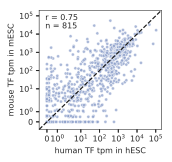

In [159]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(orth_tf_expr["mean_tpm_hESC"], 
           orth_tf_expr["mean_tpm_mESC"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 200000], [-0.75, 200000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 200000))
ax.set_ylim((-0.75, 200000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_hESC"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mESC"]))]
r, p = spearmanr(no_nan["mean_tpm_hESC"], no_nan["mean_tpm_mESC"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("../../../../for_winona/RNA-Seq/diff_expr/TF_human_v_mouse_scatter-NOut.pdf", dpi="figure", bbox_inches="tight")

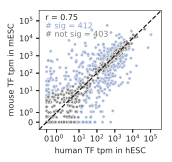

In [162]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig = orth_tf_expr[orth_tf_expr["sig"] == "sig"]
not_sig = orth_tf_expr[orth_tf_expr["sig"] == "not sig"]

ax.scatter(sig["mean_tpm_hESC"], 
           sig["mean_tpm_mESC"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")

ax.scatter(not_sig["mean_tpm_hESC"], 
           not_sig["mean_tpm_mESC"],
           color="gray", alpha=0.9, s=10, 
           linewidths=0.5, edgecolors="white")

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 400000], [-0.75, 400000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 400000))
ax.set_ylim((-0.75, 400000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_hESC"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mESC"]))]
r, p = spearmanr(no_nan["mean_tpm_hESC"], no_nan["mean_tpm_mESC"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "# sig = %s" % (len(sig)), ha="left", va="top", fontsize=fontsize, 
        color=sns.color_palette("Set2")[2],
        transform=ax.transAxes)
ax.text(0.05, 0.83, "# not sig = %s" % (len(not_sig)), ha="left", va="top", fontsize=fontsize, color="gray",
        transform=ax.transAxes)
fig.savefig("../../../../for_winona/RNA-Seq/diff_expr/TF_human_v_mouse_scatter.w_sig_outline-no_UT.pdf", dpi="figure", bbox_inches="tight")

## Voom normalized counts

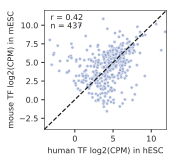

In [203]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(orth_tf_expr_voom["mean_tpm_hESC"], 
           orth_tf_expr_voom["mean_tpm_mESC"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")
#ax.set_xscale("symlog")
#ax.set_yscale("symlog")
ax.plot([-4, 12], [-4, 12], "k", linestyle="dashed")
ax.set_xlim((-4, 12))
ax.set_ylim((-4, 12))

ax.set_xlabel("human TF log2(CPM) in hESC")
ax.set_ylabel("mouse TF log2(CPM) in mESC")

# annotate corr
no_nan = orth_tf_expr_voom[(~pd.isnull(orth_tf_expr_voom["mean_tpm_hESC"])) & 
                      (~pd.isnull(orth_tf_expr_voom["mean_tpm_mESC"]))]
r, p = spearmanr(no_nan["mean_tpm_hESC"], no_nan["mean_tpm_mESC"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("../../../../for_winona/RNA-Seq/diff_expr/TF_human_v_mouse_scatter.voom_cpm.full_model.pdf", dpi="figure", bbox_inches="tight")

In [204]:
max(orth_tf_expr_voom['mean_tpm_hESC'])

11.8313812619987

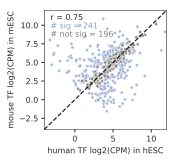

In [205]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig = orth_tf_expr_voom[orth_tf_expr_voom["sig"] == "sig"]
not_sig = orth_tf_expr_voom[orth_tf_expr_voom["sig"] == "not sig"]

ax.scatter(sig["mean_tpm_hESC"], 
           sig["mean_tpm_mESC"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")

ax.scatter(not_sig["mean_tpm_hESC"], 
           not_sig["mean_tpm_mESC"],
           color="gray", alpha=0.9, s=10, 
           linewidths=0.5, edgecolors="white")

ax.plot([-4, 12], [-4, 12], "k", linestyle="dashed")
ax.set_xlim((-4, 12))
ax.set_ylim((-4, 12))

ax.set_xlabel("human TF log2(CPM) in hESC")
ax.set_ylabel("mouse TF log2(CPM) in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_hESC"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mESC"]))]
r, p = spearmanr(no_nan["mean_tpm_hESC"], no_nan["mean_tpm_mESC"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "# sig = %s" % (len(sig)), ha="left", va="top", fontsize=fontsize, 
        color=sns.color_palette("Set2")[2],
        transform=ax.transAxes)
ax.text(0.05, 0.83, "# not sig = %s" % (len(not_sig)), ha="left", va="top", fontsize=fontsize, color="gray",
        transform=ax.transAxes)
fig.savefig("../../../../for_winona/RNA-Seq/diff_expr/TF_human_v_mouse_scatter.w_sig_outline.voom_cpm.full_model.pdf", dpi="figure", bbox_inches="tight")

## Write files

In [195]:
orth_tf_expr_f = "../../../../for_winona/RNA-Seq/diff_expr/orth_TF_expression.DESeq2.txt"
orth_tf_expr.to_csv(orth_tf_expr_f, sep="\t", index=False)

In [196]:
hESC_TF_expr_f = "../../../../for_winona/RNA-Seq/diff_expr/hESC_TF_expression.DESeq2.txt"
hESC_TFs.to_csv(hESC_TF_expr_f, sep="\t", index=False)

In [193]:
mESC_TFs = human_mouse_TFs[["gene_id_human", "gene_name_human", "gene_id_mouse", "gene_name_mouse", "mean_tpm_mouse"]].drop_duplicates()
len(mESC_TFs)

935

In [197]:
mESC_TF_expr_f = "../../../../for_winona/RNA-Seq/diff_expr/mESC_TF_expression.DESeq2.txt"
mESC_TFs.to_csv(mESC_TF_expr_f, sep="\t", index=False)

In [199]:
orth_tf_expr_f = "../../../../for_winona/RNA-Seq/diff_expr/orth_TF_expression.VOOM.txt"
orth_tf_expr_voom.to_csv(orth_tf_expr_f, sep="\t", index=False)